#### Import Libraries

In [1]:
import re
import string
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt 
import seaborn as sns
import nltk
from sklearn import metrics
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import f1_score, accuracy_score, roc_auc_score

#### Load Dataset:

In [2]:
data = pd.read_csv('data/sentiment.tsv', sep='\t')
data.columns = ['sentiment', 'tweets']
data.head()

,sentiment,tweets
0,neg,"@jamielewislewis i cant believe it, it really ..."
1,neg,Had a dream about a walk in fast food resturau...
2,neg,hates @internet @explrer (angry)(angry) **but ...
3,neg,@federalcase I said I go out for eat 5:negneg...
4,neg,@babykates7 yeah they won't do the surgery til...


### Pre-Processing:

In [3]:
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
data['sentiment'] = le.fit_transform(data['sentiment'])
data.tail()

,sentiment,tweets
1996,1,Just smashed this Tommy's for my 2PM breakfast
1997,1,@ionacosmetics spent yesterday outside myself-...
1998,1,@Covergirlneg8 I take pride in what I do
1999,1,heading to work on the 6
2000,1,@queith asi es!


##### Cleaning Data:

In [4]:
def remove_pattern(input_txt, pattern):
    r = re.findall(pattern, input_txt)
    for i in r:
        input_txt = re.sub(i, '', input_txt)
    return input_txt

##### Removing twitter handles (eg. @user)

In [5]:
data['clean_tweet'] = np.vectorize(remove_pattern)(data['tweets'], "@[\w]*")
data.head()

,sentiment,tweets,clean_tweet
0,0,"@jamielewislewis i cant believe it, it really ...","i cant believe it, it really doesnt belong th..."
1,0,Had a dream about a walk in fast food resturau...,Had a dream about a walk in fast food resturau...
2,0,hates @internet @explrer (angry)(angry) **but ...,hates (angry)(angry) **but no choice** http...
3,0,@federalcase I said I go out for eat 5:negneg...,I said I go out for eat 5:negneg p.m. I dis...
4,0,@babykates7 yeah they won't do the surgery til...,yeah they won't do the surgery till the cold ...


##### Removing Special characters, numbers, and punctuations

In [6]:
data['clean_tweet'] = data['clean_tweet'].str.replace("[^a-zA-Z#]", " ")
data.head()

C:\Users\ASUS\AppData\Local\Temp\ipykernel_8616\1410749241.py:1: FutureWarning: The default value of regex will change from True to False in a future version.
  data['clean_tweet'] = data['clean_tweet'].str.replace("[^a-zA-Z#]", " ")


,sentiment,tweets,clean_tweet
0,0,"@jamielewislewis i cant believe it, it really ...",i cant believe it it really doesnt belong th...
1,0,Had a dream about a walk in fast food resturau...,Had a dream about a walk in fast food resturau...
2,0,hates @internet @explrer (angry)(angry) **but ...,hates angry angry but no choice http...
3,0,@federalcase I said I go out for eat 5:negneg...,I said I go out for eat negneg p m I dis...
4,0,@babykates7 yeah they won't do the surgery til...,yeah they won t do the surgery till the cold ...


#### Tokenizeation of tweets:

In [7]:
tokenized_tweets = data['clean_tweet'].apply(lambda x: x.split())
tokenized_tweets.head()

0    [i, cant, believe, it, it, really, doesnt, bel...
1    [Had, a, dream, about, a, walk, in, fast, food...
2    [hates, angry, angry, but, no, choice, http, p...
3    [I, said, I, go, out, for, eat, negneg, p, m, ...
4    [yeah, they, won, t, do, the, surgery, till, t...
Name: clean_tweet, dtype: object

In [8]:
from nltk.stem.porter import PorterStemmer
stemmer = PorterStemmer()
tokenized_tweets = tokenized_tweets.apply(lambda x: [stemmer.stem(i) for i in x])
tokenized_tweets.head()

0    [i, cant, believ, it, it, realli, doesnt, belo...
1    [had, a, dream, about, a, walk, in, fast, food...
2    [hate, angri, angri, but, no, choic, http, plu...
3    [i, said, i, go, out, for, eat, negneg, p, m, ...
4    [yeah, they, won, t, do, the, surgeri, till, t...
Name: clean_tweet, dtype: object

Join the tokenized word in the same data

In [9]:
for i in range(len(tokenized_tweets)):
    tokenized_tweets[i] = ' '.join(tokenized_tweets[i])

data['clean_tweet'] = tokenized_tweets
data.head()

,sentiment,tweets,clean_tweet
0,0,"@jamielewislewis i cant believe it, it really ...",i cant believ it it realli doesnt belong there...
1,0,Had a dream about a walk in fast food resturau...,had a dream about a walk in fast food resturau...
2,0,hates @internet @explrer (angry)(angry) **but ...,hate angri angri but no choic http plurk com p...
3,0,@federalcase I said I go out for eat 5:negneg...,i said i go out for eat negneg p m i disappoin...
4,0,@babykates7 yeah they won't do the surgery til...,yeah they won t do the surgeri till the cold i...


Adding column for length and punctuation of the tweets.

In [10]:
def count_punctuation(text):
    count = sum([1 for char in text if char in string.punctuation])
    return round(count / (len(text) - text.count(" ")), 3) * 100

In [11]:
data['tweet_length'] = data['tweets'].apply(lambda x: len(x) - x.count(' '))
data['punctuation'] = data['tweets'].apply(lambda x: count_punctuation(x))
data.head() 

,sentiment,tweets,clean_tweet,tweet_length,punctuation
0,0,"@jamielewislewis i cant believe it, it really ...",i cant believ it it realli doesnt belong there...,114,4.4
1,0,Had a dream about a walk in fast food resturau...,had a dream about a walk in fast food resturau...,96,1.0
2,0,hates @internet @explrer (angry)(angry) **but ...,hate angri angri but no choic http plurk com p...,75,21.3
3,0,@federalcase I said I go out for eat 5:negneg...,i said i go out for eat negneg p m i disappoin...,58,8.6
4,0,@babykates7 yeah they won't do the surgery til...,yeah they won t do the surgeri till the cold i...,82,6.1


##### Generating word cloud:

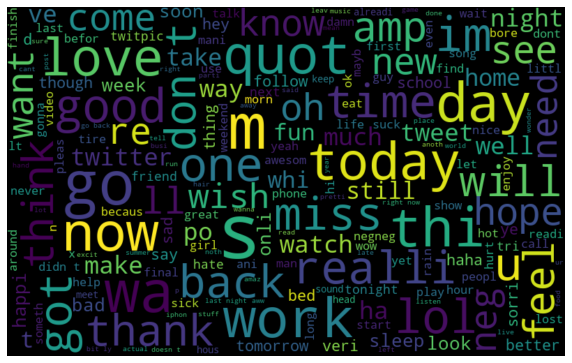

In [15]:
all_words = ' '.join([text for text in data['clean_tweet']])

from wordcloud import WordCloud
wordcloud = WordCloud(width=800, height=500,random_state=21, max_font_size = 110).generate(all_words)
plt.figure(figsize=(10, 7))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis('off')
plt.show()

 ##### Wordcloud for negative tweets

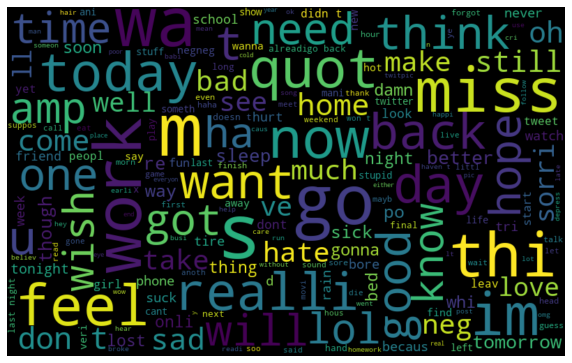

In [16]:
negative_words = ' '.join([text for text in data['clean_tweet'][data['sentiment'] == 0]])
wordcloud = WordCloud(width=800, height=500, random_state=21, max_font_size=110).generate(negative_words)
plt.figure(figsize=(10, 7))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis('off')
plt.show()

#### Feature Selection:

In [18]:
vectorizer = CountVectorizer(stop_words='english')
x = vectorizer.fit_transform(data['clean_tweet'])
x_count_features = pd.concat([data['tweet_length'], data['punctuation'],pd.DataFrame(x.toarray())], axis=1)
x_count_features.head()

,tweet_length,punctuation,0,1,2,3,4,5,6,7,...,3935,3936,3937,3938,3939,3940,3941,3942,3943,3944
0,114,4.4,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,96,1.0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,75,21.3,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,58,8.6,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,82,6.1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [20]:
from sklearn.feature_extraction.text import TfidfVectorizer

tfidf_vectorizer = TfidfVectorizer(stop_words='english')
x = tfidf_vectorizer.fit_transform(data['clean_tweet'])
x_tfidf_features = pd.concat([data['tweet_length'], data['punctuation'], pd.DataFrame(x.toarray())], axis=1)
x_tfidf_features.head()

,tweet_length,punctuation,0,1,2,3,4,5,6,7,...,3935,3936,3937,3938,3939,3940,3941,3942,3943,3944
0,114,4.4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,96,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,75,21.3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,58,8.6,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,82,6.1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
